# Imports

In [ ]:
import json
import math

import numpy as np
import pandas as pd

import pickle

import seaborn as sns
import matplotlib.pyplot as plt

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

import warnings
warnings.filterwarnings("ignore")

In [ ]:
!git clone https://github.com/nspitzern/DS-workshop-course.git
%cd DS-workshop-course/
!unzip -o songs_data_big.zip
!unzip -o songs_data_clean.zip

Cloning into 'DS-workshop-course'...
remote: Enumerating objects: 232, done.
remote: Counting objects: 100% (113/113), done.
remote: Compressing objects: 100% (72/72), done.
remote: Total 232 (delta 70), reused 84 (delta 41), pack-reused 119
Receiving objects: 100% (232/232), 415.13 MiB | 32.10 MiB/s, done.
Resolving deltas: 100% (134/134), done.
/content/DS-workshop-course/DS-workshop-course/DS-workshop-course
Archive:  songs_data_big.zip
  inflating: artists.csv             
  inflating: tracks.csv              
Archive:  songs_data_clean.zip
  inflating: artists_clean.csv       
  inflating: tracks_clean.csv        


In [ ]:
!pip install shap

import shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Util functions

In [ ]:
# Function that convert mili-second scale to minutes:
def ms2minutes(input):
    return round(input/60000,2)


# Function that do linear regression based our dataset and print scores:
def do_linearReg(df):
    y = df['popularity']
    X = df.drop(['popularity'], axis=1)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = LinearRegression()
    prediction = model.fit(X_train,y_train).predict(X_test)

    print("r2_score:","{:,.3f}".format(r2_score(y_test,prediction)))
    print("Mean Absolute Error (Σ|y-pred|/n):", "{:,.2f}".format(mean_absolute_error(y_test, prediction)))
    print("Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)):", "{:,.2f}".format(np.sqrt(mean_squared_error(y_test, prediction))))


# Function that remove outliers:
def remove_outliers(df):
    first_shape = df.shape[0]
    
    # Remove duration_mintues outliar values
    df = df.drop(df[df["duration_minutes"] > 7].index)
    # Remove year outliar values
    df = df.drop(df[df["year"] < 1926].index)
    # Remove loudness outliar values
    df = df.drop(df[df["loudness"] < -30].index)

    last_shape = df.shape[0]

    print(f"Outliers removed.\nThe outliers that remove were {round(100 * (first_shape-last_shape)/first_shape , 2)}% from the whole data.")
    return df


# **Dataset Description**
We chose the dataset of Spotify songs.

Spotify is one of the leading music streaming apps of today with more than 83 million paid subscribers.

They compile a yearly list of Top Tracks based on the number of times the songs were streamed by users.

We have been curious about what really makes a song likeable to the masses, so
our goal is to predict the popularity of each song according Spotify audio features.

# Spotify Audio Features
For every track on their platform, Spotify provides data for several Audio Features.The Spotify Web API developer guide defines them as follows:

*   **Danceability:** Describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity.

*   **Valence:** Describes the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).

*   **Energy:** Represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale.

*   **Tempo:** The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece, and derives directly from the average beat duration.

*   **Loudness:** The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks.

*   **Speechiness:** This detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value.

*  **Instrumentalness:** Predicts whether a track contains no vocals. “Ooh” and “aah” sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly “vocal”.

*   **Liveness:** Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live.

*   **Acousticness:** A confidence measure from 0.0 to 1.0 of whether the track is acoustic.

*   **Key:** The estimated overall key of the track. Integers map to pitches using standard Pitch Class notation . E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on.

*   **Mode:** Indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0.

*   **Duration:** The duration of the track in milliseconds.

*   **Time Signature:** An estimated overall time signature of a track. The time signature (meter) is a notational convention to specify how many beats are in each bar (or measure).

*   **Explicit:** The explicit logo is applied when the lyrics or content of a song or a music video contain one or more of the following criteria which could be considered offensive or unsuitable for children

*   **Genres:** The Gener of the artist of the song

*   **Year:** The year that the song relese

# Load data

In [ ]:
from loader import load_data, convert_genres

Change the `load_data` flag to `False` to preform the whole data-preprocessing from scratch.

In [ ]:
df_tracks, df_artists = load_data('.', load_data=True)

In [ ]:
df_tracks.head(3)

,song_name,popularity,duration_ms,explicit,id_artists,year,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,Carve,6,126903,0,45tIt06XoI0Iio4LBEVpls,1922,0.645,0.445,0,-13.338,1,0.4510,0.674,0.7440,0.151,0.127,104.851,3
1,Capítulo 2.16 - Banquero Anarquista,0,98200,0,14jtPCOoNZwquk5wd9DxrY,1922,0.695,0.263,0,-22.136,1,0.9570,0.797,0.0000,0.148,0.655,102.009,1
2,Vivo para Quererte - Remasterizado,0,181640,0,5LiOoJbxVSAMkBS2fUm3X2,1922,0.434,0.177,1,-21.180,1,0.0512,0.994,0.0218,0.212,0.457,130.418,5


In [ ]:
df_artists.head(3)

,id_artists,followers,genres,artist_name,artist_popularity
0,0DheY5irMjBUeLybbCUEZ2,0.0,NaN,Armid & Amir Zare Pashai feat. Sara Rouzbehani,0
1,0DlhY15l3wsrnlfGio2bjU,5.0,NaN,ปูนา ภาวิณี,0
2,0DmRESX2JknGPQyO15yxg7,0.0,NaN,Sadaa,0


The tracks table contains the features of each song, while the artists table contains meta-data about each artist.
Each song is accosiated with the artist that performed the song.

In [ ]:
original_df = df_tracks.merge(df_artists[['genres','id_artists']], on='id_artists', how='left')

Extract the genres from the artists_df

In [ ]:
original_df = convert_genres(original_df)

remove time signature of 0 (impossible)

In [ ]:
original_df = original_df[original_df.time_signature > 0]

Create data frame withoout *id_artists* and *song_name* columns, and for nice visual, we convert duration from mili second to minutes.


In [ ]:
df = original_df.copy()

# Drop id_artists and song_name column:
df.drop(['id_artists', 'song_name'], axis=1, inplace=True)

# Convert mili-second scale to minutes:
df["duration_ms"] = df["duration_ms"].apply(ms2minutes)
df.rename(columns = {"duration_ms" : "duration_minutes"}, inplace = True)

df.head()

,popularity,duration_minutes,explicit,year,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,genres
0,6,2.12,0,1922,0.645,0.4450,0,-13.338,1,0.4510,0.674,0.7440,0.151,0.127,104.851,3,UNK
1,0,1.64,0,1922,0.695,0.2630,0,-22.136,1,0.9570,0.797,0.0000,0.148,0.655,102.009,1,UNK
2,0,3.03,0,1922,0.434,0.1770,1,-21.180,1,0.0512,0.994,0.0218,0.212,0.457,130.418,5,tango
3,0,2.95,0,1922,0.321,0.0946,7,-27.961,1,0.0504,0.995,0.9180,0.104,0.397,169.980,3,tango
4,0,2.72,0,1922,0.402,0.1580,3,-16.900,0,0.0390,0.989,0.1300,0.311,0.196,103.220,4,UNK


Check if there null values

In [ ]:
df.isnull().values.any()

False

Check the types of the features

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 754300 entries, 0 to 754832
Data columns (total 17 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   popularity        754300 non-null  int64  
 1   duration_minutes  754300 non-null  float64
 2   explicit          754300 non-null  int64  
 3   year              754300 non-null  int64  
 4   danceability      754300 non-null  float64
 5   energy            754300 non-null  float64
 6   key               754300 non-null  int64  
 7   loudness          754300 non-null  float64
 8   mode              754300 non-null  int64  
 9   speechiness       754300 non-null  float64
 10  acousticness      754300 non-null  float64
 11  instrumentalness  754300 non-null  float64
 12  liveness          754300 non-null  float64
 13  valence           754300 non-null  float64
 14  tempo             754300 non-null  float64
 15  time_signature    754300 non-null  int64  
 16  genres            75

We see that genres isn't int or float, so it's must be categorical so we convert him to category

In [ ]:
df['genres'] = df['genres'].astype('category')
gen_list = df['genres'].unique().tolist()
gen2int_dict = {g:i for i,g in enumerate(gen_list)}
dummy = gen2int_dict["UNK"]
gen2int_dict[gen_list[dummy]] = dummy

In [ ]:
df['genres'] = df['genres'].map(gen2int_dict)
df

,popularity,duration_minutes,explicit,year,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,genres
0,6,2.12,0,1922,0.645,0.4450,0,-13.338,1,0.4510,0.674,0.744000,0.1510,0.1270,104.851,3,0
1,0,1.64,0,1922,0.695,0.2630,0,-22.136,1,0.9570,0.797,0.000000,0.1480,0.6550,102.009,1,0
2,0,3.03,0,1922,0.434,0.1770,1,-21.180,1,0.0512,0.994,0.021800,0.2120,0.4570,130.418,5,1
3,0,2.95,0,1922,0.321,0.0946,7,-27.961,1,0.0504,0.995,0.918000,0.1040,0.3970,169.980,3,1
4,0,2.72,0,1922,0.402,0.1580,3,-16.900,0,0.0390,0.989,0.130000,0.3110,0.1960,103.220,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
754828,72,2.55,0,2020,0.765,0.6630,0,-5.223,1,0.0652,0.141,0.000297,0.0924,0.6860,150.091,4,0
754829,70,3.13,0,2020,0.535,0.3140,7,-12.823,0,0.0408,0.895,0.000150,0.0874,0.0663,145.095,4,0
754830,58,2.37,0,2021,0.696,0.6150,10,-6.212,1,0.0345,0.206,0.000003,0.3050,0.4380,90.029,4,0
754831,58,2.37,0,2021,0.696,0.6150,10,-6.212,1,0.0345,0.206,0.000003,0.3050,0.4380,90.029,4,0


In total, after removing duplicates and illigal values in the data we remain with a dataset of size 754,300 rows and 17 columns

(16 features, 1 target).

In [ ]:
df.shape

(754300, 17)

# Test Simple Model

We now test **naive linear regression model** to predict the song popularity score

In [ ]:
from models import get_models_results, get_models

In [ ]:
model = get_models()

In [ ]:
basic_results = get_models_results(df, 'popularity', model, test_size=0.2, save_models=False, is_basic=True)

Splitting to Train/Test...
Train Size: X=(603440, 16), Y=(603440,)
Test Size: X=(150860, 16), Y=(150860,)
Running model...


In [ ]:
from visualization import get_scores_matrics

In [ ]:
get_scores_matrics([basic_results], "Linear Regression")

,RMSE,MAE,R^2
Linear Regression,14.385812,11.015836,0.434615


# Data Visualizations

We define the list of nomeric and categorical features that we have

In [ ]:
numeric_features = ['danceability', 'speechiness', 'valence', 'liveness', 
                    'energy', 'acousticness', 'instrumentalness', 'loudness',
                    'duration_minutes', 'tempo']

categorical_features = ['mode', 'explicit', 'key', 'time_signature', 'genres', 'year']

                               Visualising Categorical Features:                                


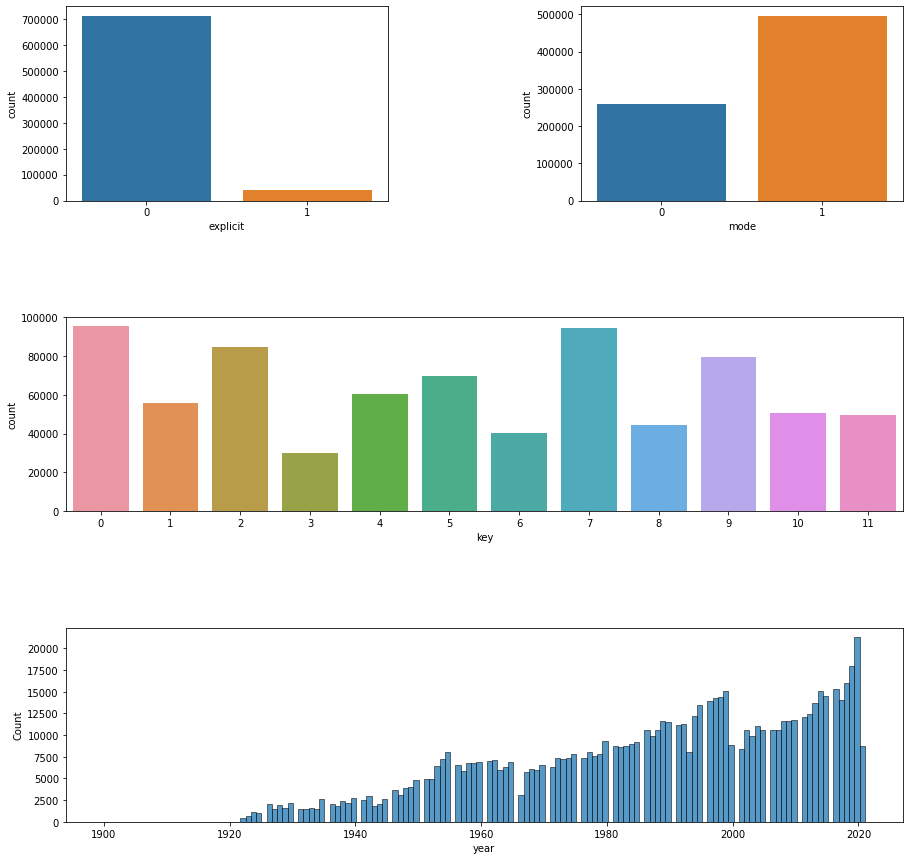

In [ ]:
#Visualising the categorical features 

print('\033[1mVisualising Categorical Features:'.center(100))

plot_cat_features = list(set(categorical_features))


fig = plt.figure(figsize=(15, 15))
grid = plt.GridSpec(3, 2, wspace=0.6, hspace=0.6)

ax1 = plt.subplot(grid[0, 0])
sns.countplot(df.explicit, ax=ax1)
ax2 = plt.subplot(grid[0, 1])
sns.countplot(df['mode'], ax=ax2)

ax3 = plt.subplot(grid[1, :])
sns.countplot(df.key, ax=ax3)

ax4 = plt.subplot(grid[2, :])
sns.histplot(df.year, ax=ax4)

plt.tight_layout()
plt.show()

                                 Numeric Features Distribution                                  


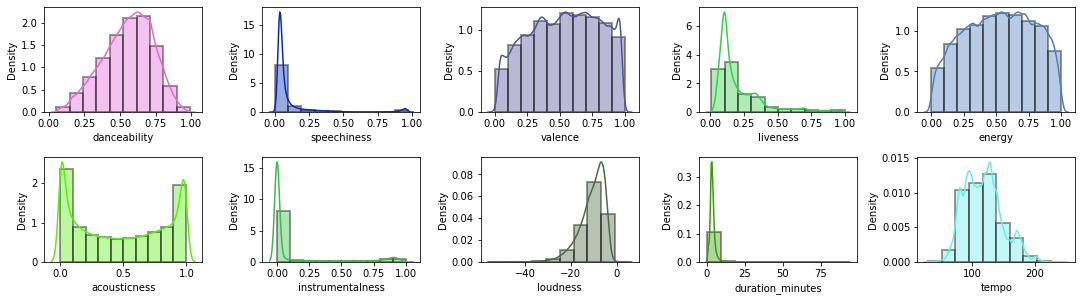

In [ ]:
#Visualising the numeric features 

print('\033[1mNumeric Features Distribution'.center(100))

n=5

clr=['r','g','b','g','b','r']

plt.figure(figsize=[15,4*math.ceil(len(numeric_features)/n)])
for i in range(len(numeric_features)):
    plt.subplot(math.ceil(len(numeric_features)/3),n,i+1)
    sns.distplot(df[numeric_features[i]],hist_kws=dict(edgecolor="black", linewidth=2), bins=10, color=list(np.random.randint([255,255,255])/255))
plt.tight_layout()
plt.show()

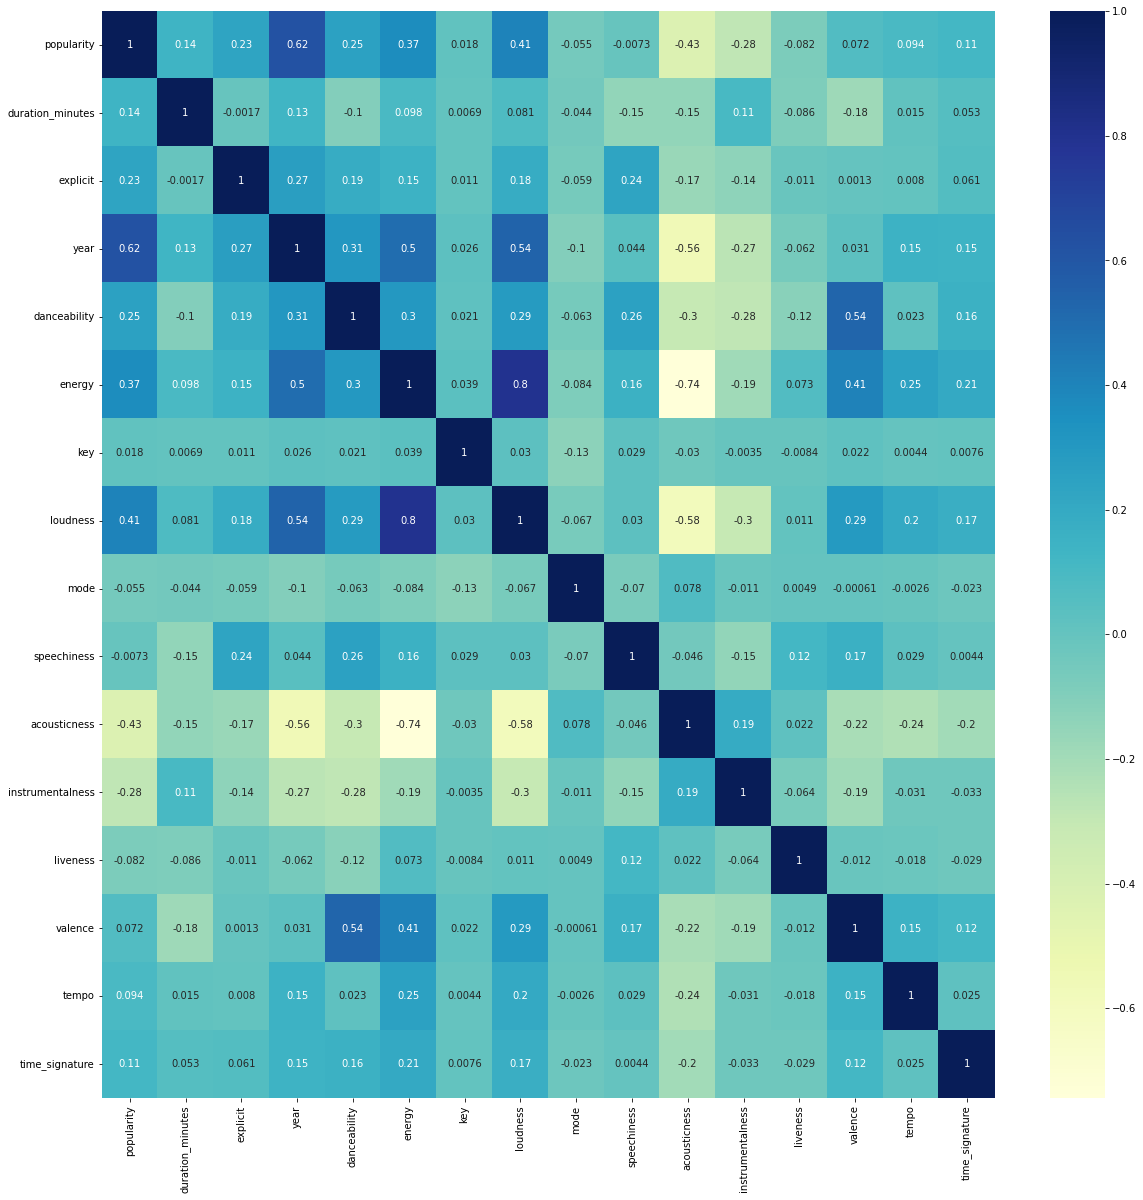

In [ ]:
fig, ax = plt.subplots(figsize=(20,20)) 

sns.heatmap(df.corr(method='spearman'), cmap="YlGnBu", annot=True,ax=ax)

Let's see the connection between Acousticness and the energy of the song.

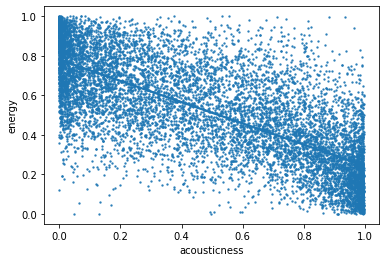

In [ ]:
sns.regplot(data=df.sample(10_000, replace=False), x='acousticness', y='energy', scatter_kws={'s':2})

This pattern shows us that acoustic songs tend be have less "energy" (Represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy).

This make sense in the manner that acoustic songs are mostly made with calm instruments and tend to be more "soft" than the original versions.

# Simple models analyzation and insights

Let's create now a version of the Train and Test sets to investigate our basic model.

In [ ]:
y = df['popularity']
X = df.drop(['popularity'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(603440, 16)
(150860, 16)
(603440,)
(150860,)


Now, let's compute the relative residuals of our model (the amout of relative error compared to the actual results).

In [ ]:
y_hat = model.predict(X_test)
residuals = y_test - y_hat

rel_res=residuals/y_test
rel_res=rel_res.abs()

In [ ]:
len(rel_res[rel_res > 0.9])/len(rel_res)

0.267963674930399

We see that in ~26% of our dataset, our relative error is more that 90%

In [ ]:
bad_predicted = df.loc[rel_res[rel_res > 0.9].index]

Get the shap values of the basic Linear Regression model.

To start the whole explainer process , change the `load_basic_lin_shap` flag to `False` (Not Recommended! The explainer process take 2.5-3 hours!) 

In [ ]:
load_basic_lin_shap = True

if load_basic_lin_shap:
    with open('basic_lin_reg_shap.pickle', 'rb') as f:
        test_shap_values = pickle.load(f)
else:
    background_data = shap.maskers.Independent(X_train, max_samples=100)
    explainer = shap.Explainer(model.predict, background_data)

    test_shap_values = explainer(X_test)

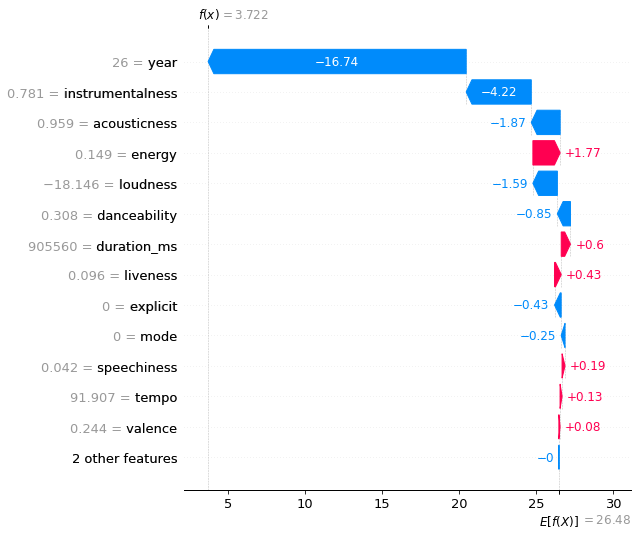

In [ ]:
shap.plots.waterfall(test_shap_values[2], max_display=14)

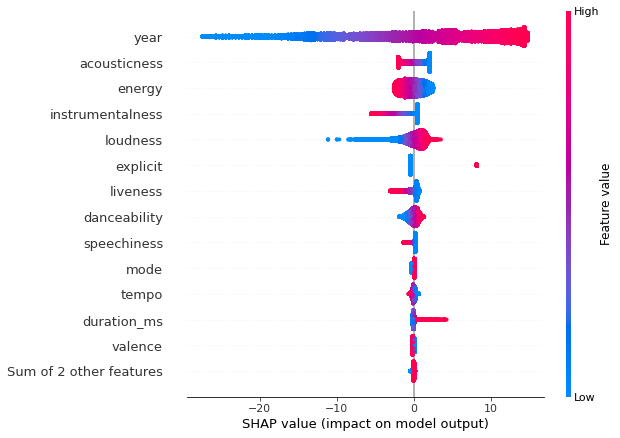

In [ ]:
shap.plots.beeswarm(test_shap_values, max_display=14)

# Outliers removal

Based on the visualization, we noticed some outliers in some of the features. We removed the outliers from the data because they are a noise and may cause difficulties in the predictions of the model

In [ ]:
df = remove_outliers(df.copy())
do_linearReg(df)

Outliers removed.
The outliers that remove were 5.71% from the whole data.
r2_score: 0.439
Mean Absolute Error (Σ|y-pred|/n): 10.95
Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)): 14.28


# One hot encoding

We wanted to  represent all the categorical features in the data. The most common method is by using One-Hot-Encoding.

In [ ]:
col_mode = pd.get_dummies(df["mode"])
col_explicit = pd.get_dummies(df["explicit"])
col_key = pd.get_dummies(df["key"])
col_time_signature = pd.get_dummies(df["time_signature"])
col_year = pd.get_dummies(df["year"])
col_genres = pd.get_dummies(df["genres"])

dfsm = pd.concat([df.drop(['explicit', 'time_signature', 'year', 'genres'], axis=1), col_explicit, col_time_signature, col_year, col_genres], axis='columns')
do_linearReg(dfsm)

r2_score: 0.476
Mean Absolute Error (Σ|y-pred|/n): 10.38
Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)): 13.81


# Feature engineering and extraction

In [ ]:
df_modified = dfsm.copy(deep=True)

### Change key+mode to scale with 1-hot

We can see in the SHAP values above that the Mode and Key features have a low importance. We would like to try and increase the importance of those features.
<br><br>
As seen in the dataset overview, the Key of a song is the scale in which the song is composed where C=0 (Do), D=2 (Re), E=4 (Mi) etc...<br>
The Mode indicates whether the song is in the Major scale or in the Minor scale wher minor=0 and major=1.
<br><br>
We wanted to combine both features into a single one (Scale) in order to increase the importance.

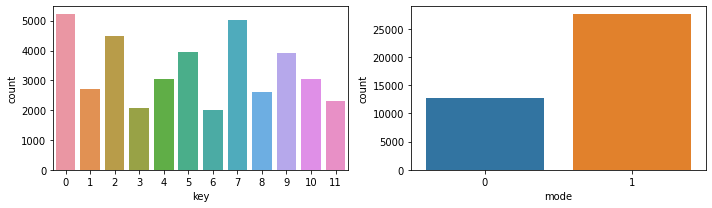

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 3))

sns.countplot(bad_predicted.key, ax=ax1)
sns.countplot(bad_predicted['mode'], ax=ax2)
plt.tight_layout()

plt.show()


For example, the song 'Cry Me A River' by Ella Fitzgerald is in Key 8=G# and Mode 0=Minor.

This means that the song is in the scale of G#m.

In [ ]:
df_tracks.loc[84544][['song_name', 'key', 'mode']]

song_name    Cry Me A River
key                       8
mode                      0
Name: 84544, dtype: object

In [ ]:
keys = {0: 'C', 1: 'C#', 2: 'D', 3: 'D#', 4: 'E', 5: 'F', 6: 'F#', 7: 'G', 8: 'G#', 9: 'A', 10: 'A#', 11: 'B'}
modes = {0: 'm', 1: ''}

df_modified['scale'] = df_modified.key.apply(lambda x: keys[x]) + df_modified['mode'].apply(lambda x: modes[x])

In [ ]:
scales_dummies = pd.get_dummies(df_modified.scale, prefix='scale')

df_modified = pd.concat([df_modified, scales_dummies], axis='columns')

df_modified.drop('scale', inplace=True, axis=1)

In [ ]:
df_modified.drop(['key', 'mode'], axis=1, inplace=True)

In [ ]:
mod_model = get_models()
improved_results = get_models_results(df_modified, 'popularity', mod_model, test_size=0.2, verbose=False)

get_scores_matrics([improved_results], "Linear Regression")

,RMSE,MAE,R^2
Linear Regression,13.798399,10.375981,0.476149


### Split Valence into bins

In the valence feature we see that the model mistakes all over the range on the feature.
<br>
We tried to split it into bins in order to have a more significent representation.

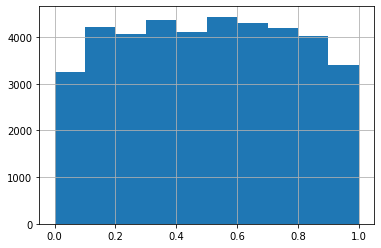

In [ ]:
bad_predicted.valence.hist()

In [ ]:
valence_bins = [0, (1/3), (2/3), 1]
valence_labels = ['sad', 'natural', 'happy']
df_modified.valence = pd.cut(df_modified.valence, bins=valence_bins, labels=valence_labels)

In [ ]:
valence_dummies = pd.get_dummies(df_modified.valence, prefix='valence')

df_modified = pd.concat([df_modified, valence_dummies], axis='columns')

df_modified.drop('valence', inplace=True, axis=1)

In [ ]:
mod_model = get_models()
improved_results = get_models_results(df_modified, 'popularity', mod_model, test_size=0.2, verbose=False)

get_scores_matrics([improved_results], "Linear Regression")

,RMSE,MAE,R^2
Linear Regression,13.797733,10.375469,0.476200


### Split tempo into bins

The model had most of its errors on the tempo feature in the meduim ranges (between 50 - 200).

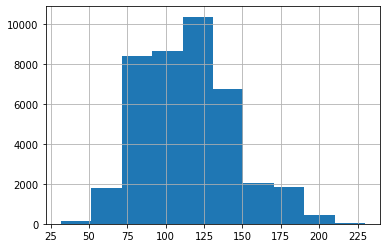

In [ ]:
bad_predicted.tempo.hist()


We have decided to split them into bins that will cluster most of the errors in the same/two classes ("moderate" and "fast" for tempo of 60-120 and 120-168 respectively. These numbers were taken from the musical definition of the tempo).

In [ ]:
df_modified.drop(df_modified[df_modified.tempo < 20].index, inplace=True)

In [ ]:
tempo_bins = [20, 60, 120, 168, 300]
tempo_labels = ['slow', 'moderate', 'fast', 'very fast']
df_modified.tempo = pd.cut(df_modified.tempo, bins=tempo_bins, labels=tempo_labels)

In [ ]:
tempo_dummies = pd.get_dummies(df_modified.tempo, prefix='tempo')

df_modified = pd.concat([df_modified, tempo_dummies], axis='columns')

df_modified.drop('tempo', inplace=True, axis=1)

In [ ]:
mod_model = get_models()
improved_results = get_models_results(df_modified, 'popularity', mod_model, test_size=0.2, verbose=False)

get_scores_matrics([improved_results], "Linear Regression")

,RMSE,MAE,R^2
Linear Regression,13.780697,10.367162,0.477492


### Split Energy into bins

The energy feature had a uniform error excpet for the part between 0.1 - 0.7.
<br>
For that reason we gave those values a class of their own while the values below and above were also split into different classes.

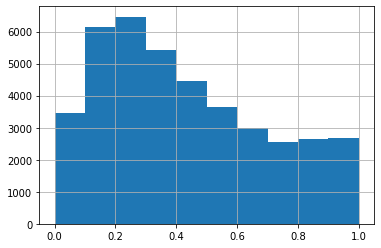

In [ ]:
bad_predicted.energy.hist()

In [ ]:
energy_bins = [0, 0.1, 0.7, 1]
energy_labels = ['low', 'avg', 'high']
df_modified.energy = pd.cut(df_modified.energy, bins=energy_bins, labels=energy_labels)

In [ ]:
energy_dummies = pd.get_dummies(df_modified.energy, prefix='energy')

df_modified = pd.concat([df_modified, energy_dummies], axis='columns')

df_modified.drop('energy', inplace=True, axis=1)

In [ ]:
mod_model = get_models()
improved_results = get_models_results(df_modified, 'popularity', mod_model, test_size=0.2, verbose=False)

get_scores_matrics([improved_results], "Linear Regression")

,RMSE,MAE,R^2
Linear Regression,13.778908,10.362093,0.477628


### Split Acousticness into bins

The acousticness feature has 2 masses of errors on the boundries of the range (around 0 and around 1) while the rest of the values don't cause much errors.

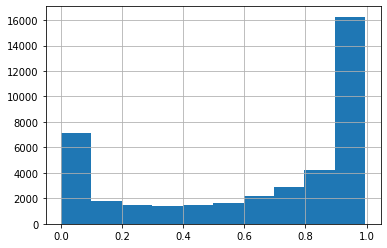

In [ ]:
bad_predicted.acousticness.hist()

For that reason, we have decided to split it into bins of 0-0.2, 0.2-0.4, 0.4-0.6, 0.6-0.8 and 0.8-1.0 which are equivalent to the bins of "low", "low-avg", "avg", "high-avg" and "high".

In [ ]:
acousticness_bins = [0, 0.2, 0.4, 0.6, 0.8, 1]
acousticness_labels = ['low', 'low-avg', 'avg', 'avg-high', 'high']
df_modified.acousticness = pd.cut(df_modified.acousticness, bins=acousticness_bins, labels=acousticness_labels)

In [ ]:
acousticness_dummies = pd.get_dummies(df_modified.acousticness, prefix='acousticness')

df_modified = pd.concat([df_modified, acousticness_dummies], axis='columns')

df_modified.drop('acousticness', inplace=True, axis=1)

In [ ]:
mod_model = get_models()
improved_results = get_models_results(df_modified, 'popularity', mod_model, test_size=0.2, verbose=False)

get_scores_matrics([improved_results], "Linear Regression")

,RMSE,MAE,R^2
Linear Regression,13.768426,10.355182,0.478422


### Split Loudness into bins

For the loudness feature we saw that most of the errors are in the medium ranges (between -30 and -5) which lands in the 0.15 and 0.85 quantiles respectively.

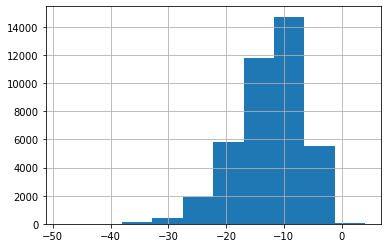

In [ ]:
bad_predicted.loudness.hist()


We splitted the feature into bins according to those values with the indications of "quiet", "avg" and "loud".

In [ ]:
loudness_bins = [df.loudness.min(), df.loudness.quantile(.15), df.loudness.quantile(.85) , df.loudness.max()]

loudness_labels = ['quiet', 'avg', 'loud']
df_modified.loudness = pd.cut(df_modified.loudness, bins=loudness_bins, labels=loudness_labels)

In [ ]:
loudness_dummies = pd.get_dummies(df_modified.loudness, prefix='loudness')

df_modified = pd.concat([df_modified, loudness_dummies], axis='columns')

df_modified.drop('loudness', inplace=True, axis=1)

In [ ]:
mod_model = get_models()
improved_results = get_models_results(df_modified, 'popularity', mod_model, test_size=0.2, verbose=False)

get_scores_matrics([improved_results], "Linear Regression")

,RMSE,MAE,R^2
Linear Regression,13.746083,10.335805,0.480114


### Split instrumentalness into bins

In the instrumentalness feature, most of the errors were made in the range of 0-0.2 values.

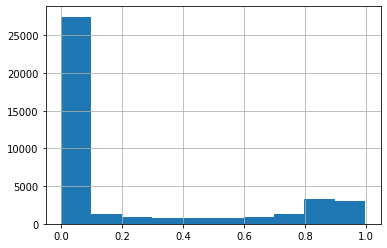

In [ ]:
bad_predicted.instrumentalness.hist()


We have decided to combine all of those into a different class and also gather all values between 0.2-0.8 and 0.8-1.0 into 2 different classes.

In [ ]:
instrumentalness_bins = [0, 0.2, 0.8, 1]

instrumentalness_labels = ['low instrumental', 'avg instrumental', 'high instrumental']
df_modified.instrumentalness = pd.cut(df_modified.instrumentalness, bins=instrumentalness_bins, labels=instrumentalness_labels)

In [ ]:
instrumentalness_dummies = pd.get_dummies(df_modified.instrumentalness, prefix='instrumentalness')

df_modified = pd.concat([df_modified, instrumentalness_dummies], axis='columns')

df_modified.drop('instrumentalness', inplace=True, axis=1)

In [ ]:
mod_model = get_models()
improved_results = get_models_results(df_modified, 'popularity', mod_model, test_size=0.2, verbose=False)

get_scores_matrics([improved_results], "Linear Regression")

,RMSE,MAE,R^2
Linear Regression,13.737477,10.326683,0.480765


# Test improved Models

Let's put it all together and compare between the basic model and the improved model:

In [ ]:
X_mod = df_modified.drop(['popularity'], axis=1)
y_mod = df_modified['popularity']
X_train_mod, X_test_mod, y_train_mod, y_test_mod = train_test_split(X_mod, y_mod, test_size=0.2, random_state=42)

Train Model

In [ ]:
model = LinearRegression().fit(X_train_mod, y_train_mod)

y_hat_mod = model.predict(X_test_mod)

rmse = mean_squared_error(y_test_mod, y_hat_mod, squared=False)
mae = mean_absolute_error(y_test_mod, y_hat_mod)
r2 = r2_score(y_test_mod, y_hat_mod)

improved_results = {'RMSE': rmse, 'MAE': mae, 'R^2': r2}

In [ ]:
combined_results = [
    basic_results,
    improved_results
]

get_scores_matrics(combined_results, "Linear Regression", "Improved Model")

,RMSE,MAE,R^2
Linear Regression,14.385812,11.015836,0.434615
Improved Model,13.737477,10.326683,0.480765


In [ ]:
from collections import defaultdict

data = defaultdict(list)

for model_results in combined_results:
    data['RMSE'].append(model_results['RMSE'])
    data['MAE'].append(model_results['MAE'])
    data['R^2'].append(model_results['R^2'])

scores = pd.DataFrame({
    'Score': ['RMSE', 'MAE', 'R^2'], 
    'Basic Model': [data['RMSE'][0], data['MAE'][0], data['R^2'][0]],
    'Improved Model': [data['RMSE'][1], data['MAE'][1], data['R^2'][1]],
})

In [ ]:
scores = scores.melt(id_vars='Score').rename(columns=str.title)

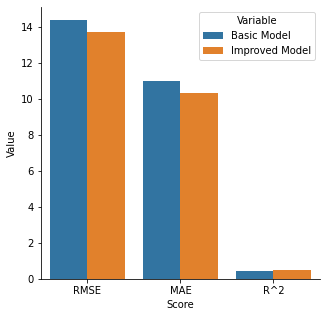

In [ ]:
fig, ax1 = plt.subplots(figsize=(5, 5))
sns.barplot(
    data=scores,
    x='Score',
    y='Value',
    hue='Variable',
    ax=ax1
)

sns.despine(fig)

The improved model has some significent advantage over the basic model.

The $MAE$ dropped in 0.069 scores, the $RMSE$ dropped in 0.65 scores and the $R^2$ increased in 0.044 scores.

# Conclusion

We have to examined the ability to predict the popularity score of a song, based on several Spotify features with linear regression model.

After preproccesing the data and dealing with missing values, we did some analyzations of the model and the errors it made.
<br>
Based on those analyzations we used several methods and approaches to improve our naive model (outliers remove, encoding categorical features, feature engeeniring etc...)

We also tried other methods but they didn't make a significant improve (use standard and minmax scaler, ordinal encoding, data transformation, using diffrent models etc...)

Thank for the course!

Nadav and Daniel
